In [1]:
import sys
import os
import time
import numpy as np
import theano
import theano.tensor as T
import lasagne
import pandas as pd
from util import *
from archs import *
from load_data import *
import train as tr
from network import MNKNet

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(985227)
datafile = '../../Google Drive/Bas Zahy Gianni - Games/Data/0_hvh/Clean/_summaries/model_input_with_groups.csv'

sns.set_style('white')
sns.set_context('poster')
%matplotlib inline

This and other notebooks are scratch pads to try ideas out or debug small features before integrating with more proper secripts

### Some custom functions

#### Archs - prototypes

More archs are imported from archs.py

### Single architecture training

For prototyping

In [5]:
ARCH = softmax_agent
LVL = None
arch = lambda input_var=None: ARCH(nfil=lvl, input_var=input_var)

CV_nlls, traces, nets = tr.CV_train(
    arch, 
    batchsize=500, 
    epochs=5000, 
    thresh=100,
    everyn=100,
    custom_loaded=CV_loader(datafile)
)

Compiling Theano expressions...
Loading data...
[(1116, 2, 4, 9), (1092, 2, 4, 9), (1099, 2, 4, 9), (1092, 2, 4, 9), (1083, 2, 4, 9)]
Ntrials = 13228
Epoch 1 of 5000 took 0.069s
  training loss:		3.2612
  validation loss:		3.2292
  validation accuracy:		7.80
  total time elapsed:		0.069s


/Users/gianni/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


Epoch 101 of 5000 took 0.069s
  training loss:		2.6497
  validation loss:		2.7009
  validation accuracy:		17.30
  total time elapsed:		6.763s
Epoch 201 of 5000 took 0.065s
  training loss:		2.5886
  validation loss:		2.6660
  validation accuracy:		16.20
  total time elapsed:		13.340s
Epoch 301 of 5000 took 0.063s
  training loss:		2.5670
  validation loss:		2.6596
  validation accuracy:		17.30
  total time elapsed:		19.810s
Epoch 401 of 5000 took 0.064s
  training loss:		2.5572
  validation loss:		2.6592
  validation accuracy:		18.30
  total time elapsed:		26.281s
Validation error stopped decreasing...
Abandon ship!
Final results:
  Stopped in epoch:			411
  test loss:			2.721262
  test accuracy:		17.60 %
Compiling Theano expressions...
Loading data...
[(1116, 2, 4, 9), (1092, 2, 4, 9), (1099, 2, 4, 9), (1092, 2, 4, 9), (1083, 2, 4, 9)]
Ntrials = 13132
Epoch 1 of 5000 took 0.064s
  training loss:		3.2762
  validation loss:		3.2243
  validation accuracy:		8.00
  total time elapsed:		0.0

### Architecture comparison

(DON'T do this unless you want to train 18 different networks. Load params or remove loop to train the architecture you want instead.)

In [14]:
np.random.seed(985227)
datafile = '../../Google Drive/Bas Zahy Gianni - Games/Data/0_hvh/Clean/_summaries/model_input_with_groups.csv'

CVN, TRACES, NETS = ([],)*3
ARCHS = [naive_agent, smart_agent]
ARCH_NAMES = ['naive', 'smart']
LVLS = 2**np.arange(9)


for lvl in LVLS:
    for aidx, arch in enumerate(ARCHS):
        np.random.seed(985227)
        CV_nlls, traces, nets = tr.CV_train(
            lambda input_var=None: arch(nfil=lvl, input_var=input_var),
            batchsize=500, 
            epochs=5000, 
            thresh=100,
            everyn=5000,
            custom_loaded=custom_loader(datafile)
        )
        
        CVN.append(CV_nlls)
        TRACES.append(traces)
        NETS.append(nets)
        
        print(
            '\n',
            ARCH_NAMES[aidx] + ' ' + 'LVL' + ' ' + str(lvl) + ':\t',
            np.mean(CV_nlls),
            '\n'
        )
        
        save_appended_data(
            nets, 
            ARCH_NAMES[aidx] + '_' + str(lvl)
        )

Compiling Theano expressions...


KeyboardInterrupt: 

### Save traces and parameters

In [25]:
CVN = CVN[::3]
TRACES = TRACES[1::3]
NETS = NETS[2::3]

In [43]:
for i, t in enumerate(TRACES):
    np.savetxt(
        './results/trace_' + str(i) + '.csv', 
        np.array(t).reshape([15, 5000]).T, 
        delimiter=','
    )
    
for i, n in enumerate(NETS):
    for j, nn in enumerate(n):
        nn.save_params('./results/params_' + str(i*len(nets) + j))

# Some unorganized junk

### Separate data file

In [17]:
datadir = '../../Google Drive/Bas Zahy Gianni - Games/Data/0_hvh/Clean/_summaries/'
datafile = datadir + 'model_input_with_groups.csv'
datatypes = [('subject', 'i4'), ('color', 'i4'), 
                 ('bp', 'S36'), ('wp', 'S36'), 
                 ('response', 'i4'), ('rt', 'i4'), ('splitg', 'i4')]
data = np.loadtxt(datafile, delimiter=',', dtype=datatypes)
data = pd.DataFrame.from_records(data)
decoder = lambda x: x.decode('utf-8')
data.loc[:, 'bp'] = data.loc[:, 'bp'].map(decoder)
data.loc[:, 'wp'] = data.loc[:, 'wp'].map(decoder)
data.loc[data.subject==0, :].to_csv(datadir + 'sub0.csv', header=False, index=False)

### Load Params (if you skipped training)

(to do! pretty easy though)

### Save transferable params

(needs updated)

In [32]:
params = lasagne.layers.get_all_param_values(n.network)

for i, p in enumerate(params):
    ps = p.shape
    pp = p.reshape([ps[0], np.product(ps[1:])])
    np.savetxt(str(i//2) + str(i%2)+'b', pp, fmt='%.10f')

AttributeError: 'int' object has no attribute 'network'

# Figures

TODO: move to the results notebook

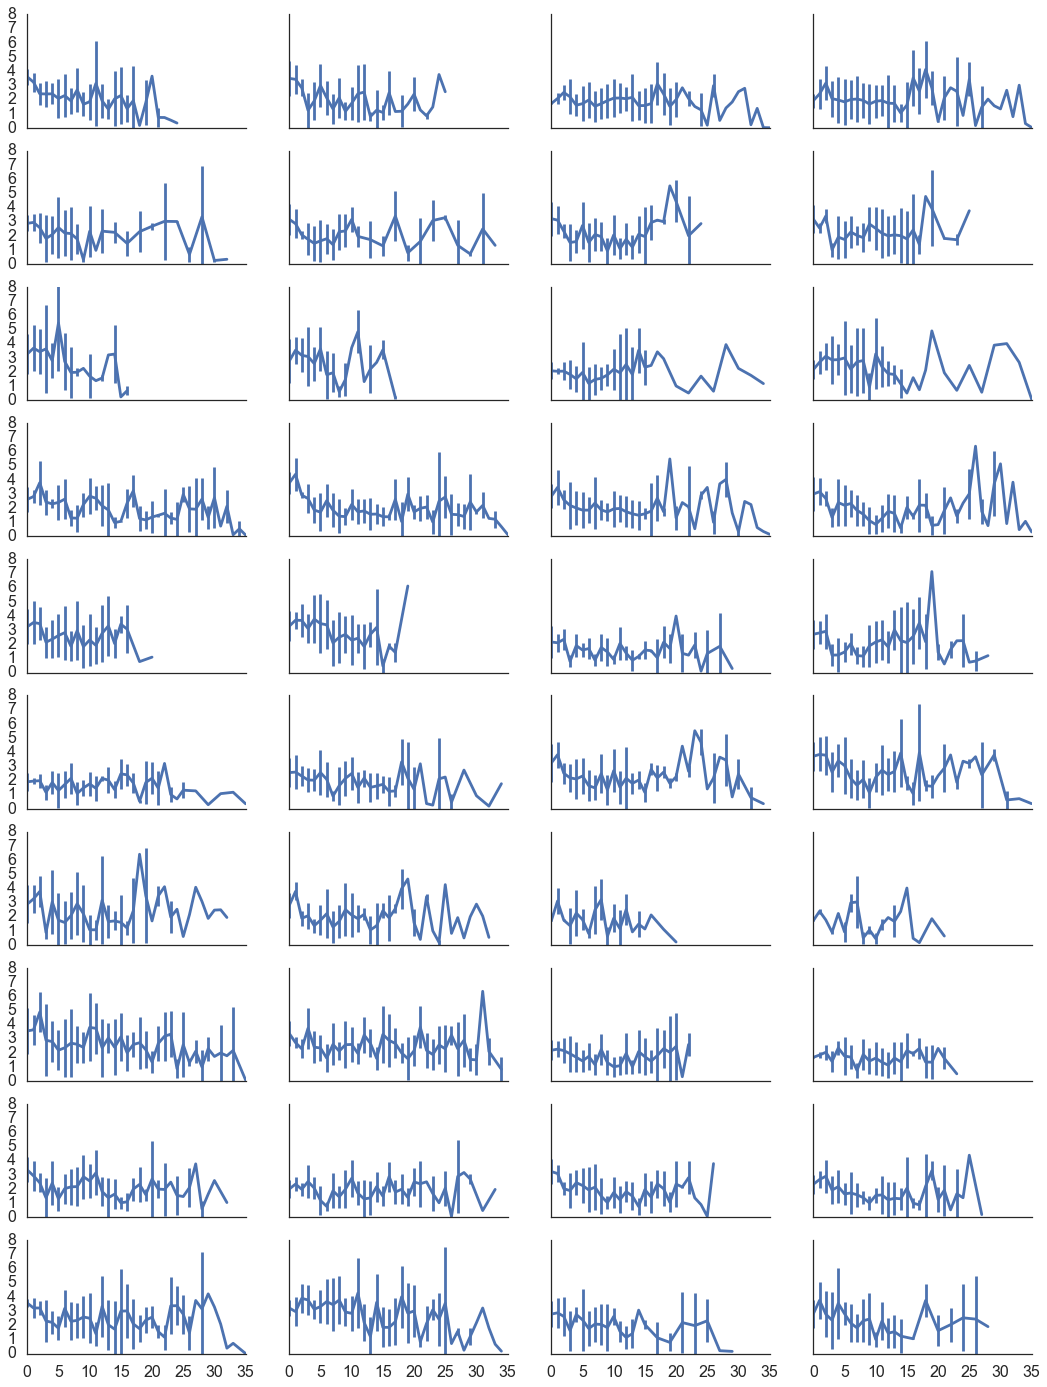

In [76]:
def agg_nlls(data):
    meanagg = pd.pivot_table(data=data, 
                   values='cnn_nll', index='n_pieces', 
                   aggfunc=np.mean)
    sdagg = pd.pivot_table(data=data,
                          values='cnn_nll', index='n_pieces',
                          aggfunc=np.std)
    return meanagg, sdagg

figs, axes = plt.subplots(10, 4, figsize=(18,24), 
                          sharex=True, sharey=True)

for p in data.subject.unique():
    ax = axes.flatten()[p]
    m, sd = agg_nlls(data.loc[data.subject==p])
    ax.errorbar(m.index, m.values, yerr=sd.values)
    ax.set_ylim([0,8])
    
sns.despine()

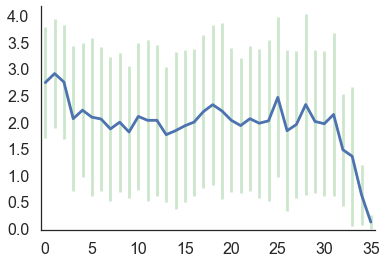

In [77]:
m, sd = agg_nlls(data)
plt.errorbar(m.index, m.values, yerr=sd.values, ecolor=(.8, .9, .8))
ax = plt.gca()
ax.set_ylim([0,4.2])
ax.set_xlim([-.5, 35.5])
sns.despine()
fig = plt.gcf()
fig.savefig('./nll_against_n_pieces')

2
[[ 0.01813535  0.          0.          0.          0.          0.
   0.02467455  0.          0.00538274]
 [ 0.00070528  0.00448624  0.          0.          0.          0.
   0.30124983  0.04422221  0.00091078]
 [ 0.00062544  0.00663958  0.12325179  0.          0.          0.
   0.11674204  0.020159    0.0027437 ]
 [ 0.00123004  0.01162244  0.          0.          0.          0.          0.
   0.29957927  0.01763971]]


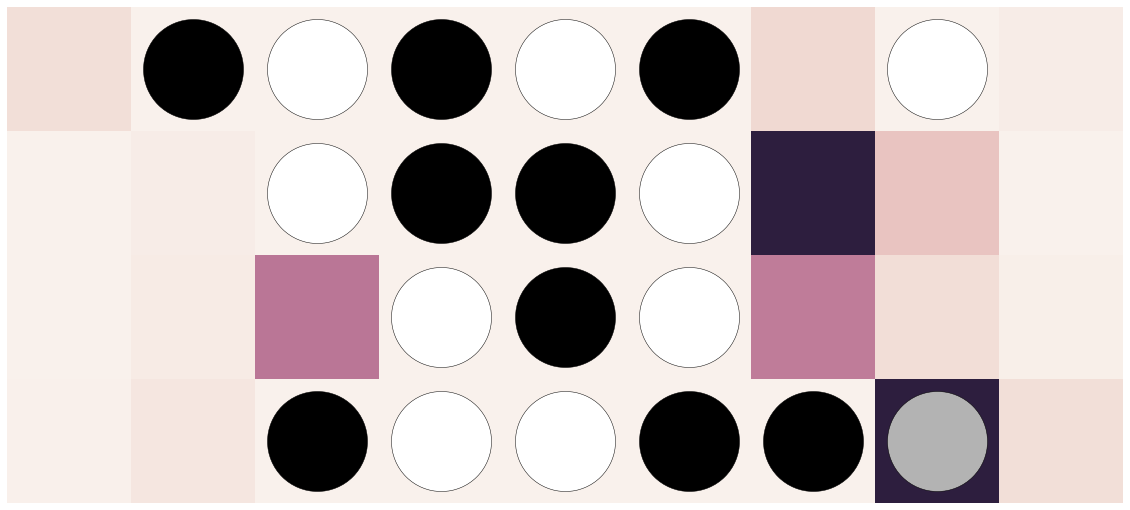

In [85]:
pos = 506
print(data.loc[pos, 'subject'])
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
d = data.loc[pos, positions].values.reshape([4,9]).astype(float)
print(d)
sns.heatmap(
    d, square=True, vmin=0, vmax=.25, cbar=False,
    xticklabels=False, yticklabels=False, ax=axes, annot=True
)

reconstitute = lambda x: np.array(list(map(int, x))).reshape(4,9)

if data.loc[pos, 'color'] == 0:
    own_color, opp_color = 'black', 'white'
else:
    own_color, opp_color = 'white', 'black'

p = np.where(reconstitute(data.loc[pos, 'bp'])==1)
plt.scatter( .5 + p[1], 3.5 - p[0], c=own_color, s=10000)
p = np.where(reconstitute(data.loc[pos, 'wp'])==1)
plt.scatter( .5 + p[1], 3.5 - p[0], c=opp_color, s=10000)
r = data.loc[pos, 'response']
p = (r % 9, r // 9)
plt.scatter(p[0] + .5, 3.5 - p[1], c=(.7, .7, .7), s=10000);
fig.savefig('nice example.png', bbox_inches='tight')

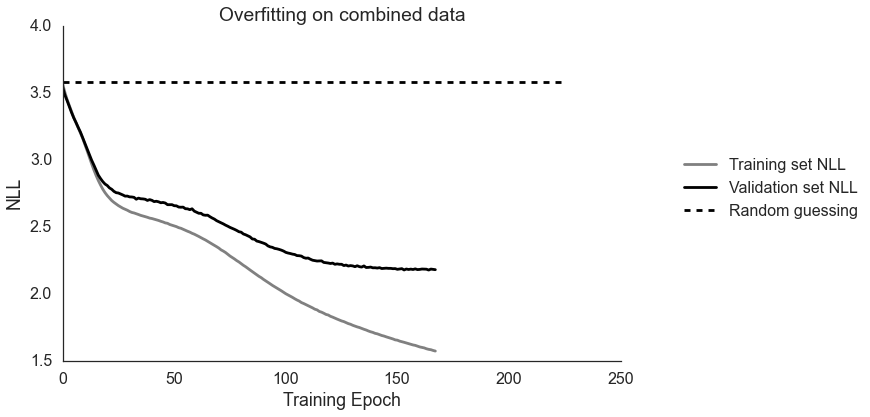

In [15]:
fig, axes = plt.subplots(1, 1, figsize=(10,6), squeeze=False)
ep = net.last_epoch
ax = axes[0,0]
ax.plot(np.arange(net.tr_nll.size)[:ep], net.tr_nll[:ep]/33, 
         label='Training set NLL', color='grey')
ax.plot(np.arange(net.val_nll.size)[:ep], net.val_nll[:ep]/5, 
         label='Validation set NLL', color='black')
ax.plot([0, 200], [3.58, 3.58], 'k--', label='Random guessing')
lgd = ax.legend(bbox_to_anchor=(1.45, .65))
ax.set_xlabel('Training Epoch')
ax.set_ylabel('NLL')
ax.set_title('Overfitting on combined data')
sns.despine()
fig.savefig('training_slope.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

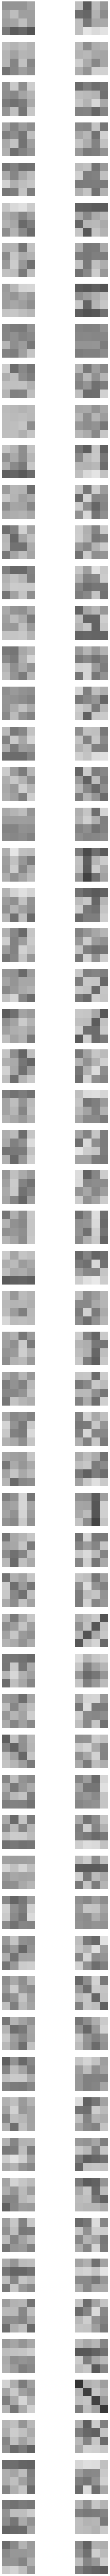

In [42]:
fig, axes = plt.subplots(64, 2, figsize=(10, 192), squeeze=False)

filters = lasagne.layers.get_all_param_values(n.network)[0]

for idx in range(64):
    sns.heatmap(filters[idx,0], square=True, cmap='Greys', fmt= '.2f', 
                vmin=-1.5, vmax=1.5, annot=True,
                ax=axes[idx,0], cbar=False, xticklabels=False, yticklabels=False)
    sns.heatmap(filters[idx,1], square=True, cmap='Greys', fmt='.2f', 
                vmin=-1.5, vmax=1.5, annot=True,
                ax=axes[idx,1], cbar=False, xticklabels=False, yticklabels=False)

fig.savefig('filters.png', bbox_inches='tight')